In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

<span style="color:olive">

### **general**

I will use a signal-to-noise of 1. This means that the minimum signal must be equal or higher than the noise (noise ~ detection limitation).

planet images from https://nineplanets.org/planets-transparent-background/

In [2]:
def getImage(path, zoom=.05):
    return OffsetImage(plt.imread(path), zoom=zoom)

In [3]:
exo = pd.read_csv("exoplanets.csv")
exo["discoverymethod"].unique()

array(['Radial Velocity', 'Imaging', 'Eclipse Timing Variations',
       'Transit', 'Transit Timing Variations', 'Astrometry',
       'Microlensing', 'Disk Kinematics', 'Orbital Brightness Modulation',
       'Pulsation Timing Variations', 'Pulsar Timing'], dtype=object)

<span style="color:brown">

### **radial velocity technique (RV)**

<span style="color:orange">

radial velocity is limited by the ability to detect a radial velocity amplitude. one of the best radial velocity surveys is ESPRESSO. it has an instrumental precision of .1 m/s, and when considering photon noise and stellar jitter, this conservatively gets to .5 m/s.  
https://www.aanda.org/articles/aa/full_html/2021/01/aa38306-20/aa38306-20.html

the velocity semi-amplitude, K, is calculated with   
#### $ K = 28.4 \textrm{ms}^{-1} \left(\frac{a}{1 \textrm{AU}}\right)^{-1/2} \left(\frac{M_p \sin{i}}{M_J}\right) \left(\frac{M_{*}}{M_{⊙}}\right)^{-1/2} $  
we will assume inclination of 90 degrees and a sun-like star for the mass, simplifying the equation. however, it is important to a lower inclination and a smaller star will decrease the velocity semi-amplitude. if we fix K .5 m/s, and convert $M_J$ to $M_⨁$, we get a functional relationship  
#### $ \frac{M_p}{M_⨁} = 317.9 \left(\frac{0.5 \textrm{ms}^{-1}}{28.4 \textrm{ms}^{-1}}\right) \left(\frac{a}{1 \textrm{AU}}\right)^{1/2} $

In [4]:
def rv(a,min_k):
    return a,317.9*(min_k/28.4)*(a)**0.5

<span style="color:brown">

### **transits**

<span style="color:orange">

detecting transits is limited by te ratio between the exoplanet and its host star, as that is what causes the transit depth signature in the magnitude. however, it is also practically limited by the amount of time we have to actually detect the transit events. I will take Kepler as an example mission, which was operational for ~3.5 years with observations every 30 minutes.  

due to the length of the survey, there is a hard cut-off on period, and therefore semi-major axis. usually, two transit observations are needed to defintely define the planet, so 3.5 will be first divided by 2 to allow for 2 observations within the 4 years. with units kept consistent at years and AU,  
#### $ P^2 = a^3 \implies \left({3.5/2}\right)^2 = {a}^3 \implies a = 1.21 \textrm{AU}$


the transit detection is also limited for low mass planets, as low mass generally correlates to low radii, which means low transit depth. neglecting limb darkening, the transit depth $\delta$ is  
#### $ \delta = \left(\frac{R_p}{R_s}\right)^2$  
don't know how to use this. will use https://iopscience.iop.org/article/10.1088/0004-637X/809/1/8#apj517109s5 and https://github.com/mtpenny/wfirst-ml-figures/blob/master/sensitivity/sensitivity.py

In [5]:
def tr(a,max_a):
    a = a[a<max_a]
    return a,2.2*(a/max_a)**0.75

<span style="color:brown">

### **astrometry**

<span style="color:orange">

astrometry is a question of resolution in images, to see the small movements that a star experiences because of the planet. I will use Gaia astrometry as an example, which covers 34 months of data. gaia claims a precision of 24 microarcseconds, and this will become the bound. assuming a sun-like star at 20 pc, the size of the signal is  
#### $ \alpha = 0.3 \mu \textrm{as} \left(\frac{a}{1 \textrm{AU}}\right) \left(\frac{M_p}{M_⨁}\right) \left(\frac{20 pc}{10 pc}\right)^{-1}$  
considering the precision of 24, and rearranging the equation, we get  
#### $ \left(\frac{M_p}{M_⨁}\right) = \left(\frac{24 \mu \textrm{as}}{0.3 \mu \textrm{as}}\right) \left(\frac{20 pc}{10 pc}\right) \left(\frac{a}{1 \textrm{AU}}\right)^{-1}$  

also, note the cutoff at 34 months (started data in July 2014). using Kepler's third law,  
#### $ P^2 = a^3 \implies \left({34/12}\right)^2 = {a}^3 \implies a = 2.00\textrm{AU}$

https://www.esa.int/Science_Exploration/Space_Science/Gaia_overview

In [6]:
def ast(a,prec,d,max_a):
    a = a[a<max_a]
    return a,prec/0.3*d/10*a**(-1)

<span style="color:brown">

### **microlensing**

<span style="color:orange">

WFIRST

#### $ \log{\frac{M_p}{M_⨁}} = \alpha + \beta \log{\frac{a}{1 \textrm{AU}}} + \gamma \sqrt{\delta^2+\left( \log{\frac{a}{1 \textrm{AU}}} - \epsilon \right)^2 } $  
with $\alpha = -3.90$, $\beta = -1.15$, $\gamma = 3.56$, $\delta = 0.783$, and $\epsilon = 0.356$.

https://iopscience.iop.org/article/10.3847/1538-4365/aafb69/pdf

In [7]:
def ml(a):
    return a,10**(-3.9 - 1.15*np.log10(a) + 3.56*np.sqrt(0.783**2 + (np.log10(a) - 0.356)**2))

<span style="color:brown">

### **pulsar timing**

<span style="color:orange">

the timing amplitude coming from a pulsar orbiting about a center of mass with an exoplanet can be characterized by 

$\tau_p = \frac{1}{c} \frac{a\sin{i} M_p}{M_*} $

assuming no $\sin{i}$ degeneracy, and a sun-like star, this equation can be rewritten as

$ M_p = \frac{c M_* \tau_p}{a} $

to cancel units

$ \frac{M_p}{M_⨁} = c \frac{1 AU}{1.496e+11 m} \frac{M_*}{M_⨁} \tau_p \frac{1 \textrm{AU}}{a} $

Nançay radiotelescope can detect precision up to 1 mu second, potentially under 500 ns. This is when detecting pulsars.

$ \frac{M_p}{M_⨁} = 3e8 * \frac{1 AU}{1.496e+11 m} * 330000 * 1.46 * 1e-6 * \frac{1 \textrm{AU}}{a} $


average pulsar around 1.46 mass of sun https://www.aanda.org/articles/aa/abs/2011/03/aa15532-10/aa15532-10.html

In [8]:
def ps(a,tau):
    return a,3e8/1.496e11 * 333030*1.46*tau*1/a

---

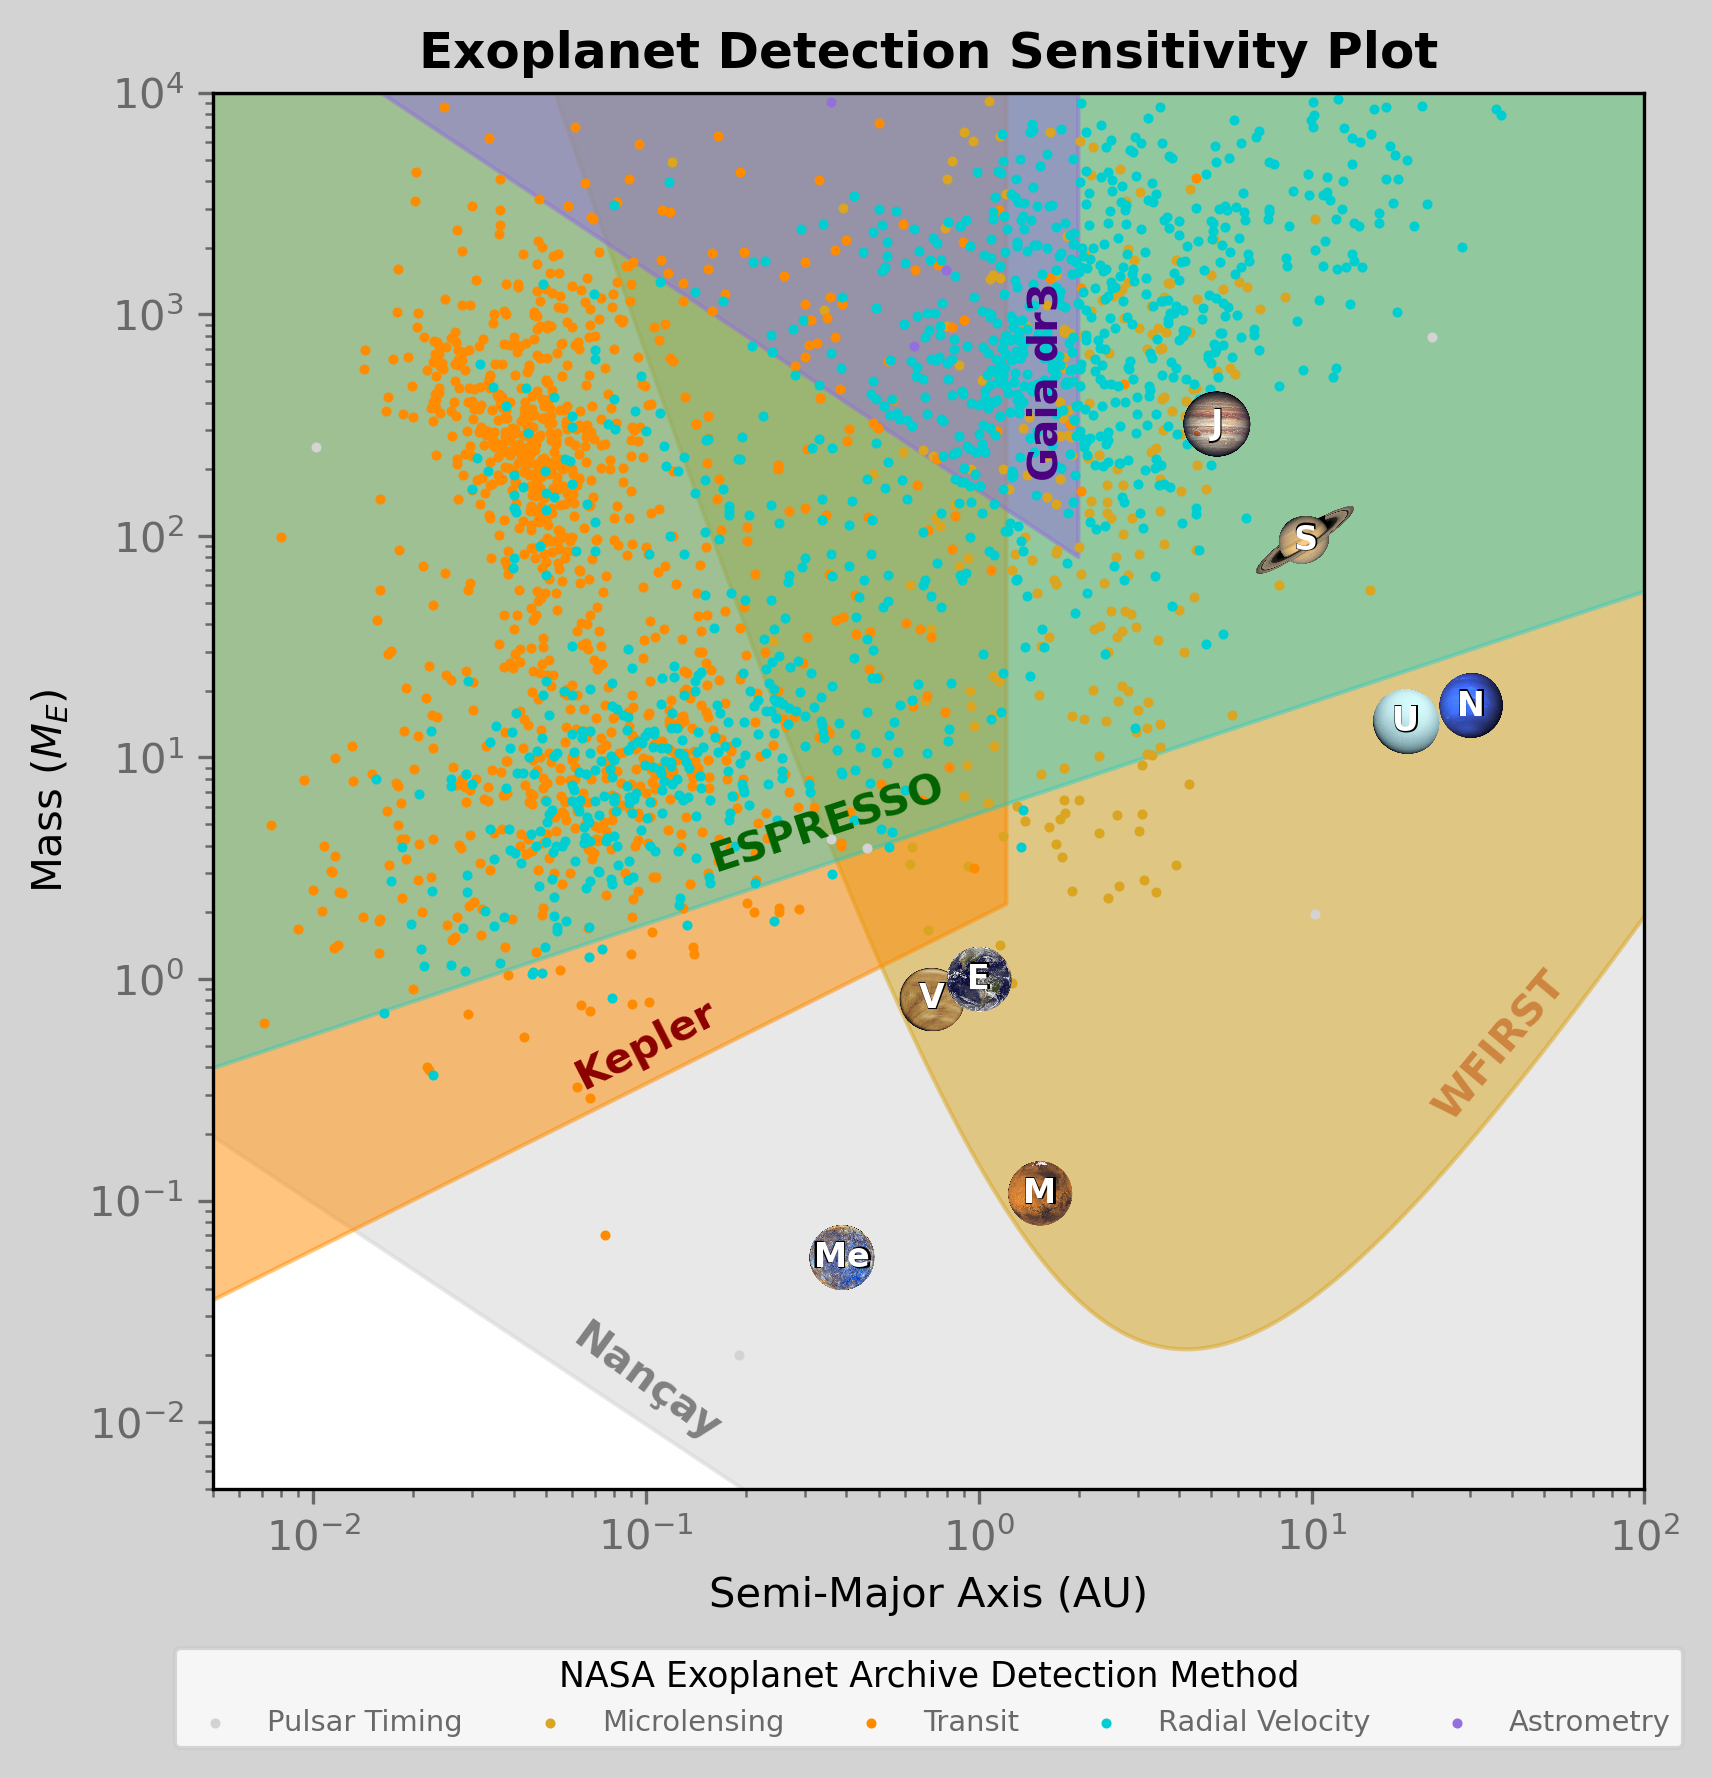

In [9]:
fig,ax = plt.subplots(figsize=(6,6), dpi=300)
fig.set_facecolor("lightgray")
ax.set_title("Exoplanet Detection Sensitivity Plot",weight="bold",color="black")



paths = ['mercury.png','venus.png','earth.png','mars.png',
         'jupiter.png','saturn.png','uranus.png','neptune.png']

x = np.array([57.9,108.2,149.6,228.0,778.5,1432.0,2867.0,4515.0])*1e6/1.496e8
y = np.array([0.330,4.87,5.97,0.642,1898,568,86.8,102])*1e24/5.972e24
labs = np.array(["Me","V","E","M","J","S","U","N"])

ax.scatter(x, y, alpha=0) 
for x0, y0, lab, path in zip(x, y, labs, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
    ax.text(x0,y0,lab,va="center",ha="center",color="black",weight="bold",size=9)
    ax.text(x0,y0,lab,va="center",ha="center",color="white",weight="bold",size=8)




a = np.logspace(-3,3,1000)

ax.fill_between(ps(a,1e-6)[0],ps(a,1e-6)[1],1e4,alpha=0.5,color="lightgray")
ax.text(0.1,0.015,"Nançay",va="center",ha="center",color="gray",weight="bold",rotation=-36)

ax.fill_between(ml(a)[0],ml(a)[1],1e4,alpha=0.5,color="goldenrod")
ax.text(37,0.5,"WFIRST",va="center",ha="center",color="peru",weight="bold",rotation=50)

ax.fill_between(tr(a,1.21)[0],tr(a,1.21)[1],1e4,alpha=0.5,color="darkorange")
ax.text(0.1,0.5,"Kepler",va="center",ha="center",color="darkred",weight="bold",rotation=27)

ax.fill_between(rv(a,.5)[0],rv(a,.5)[1],1e4,alpha=0.35,color="darkturquoise")
ax.text(0.35,5,"ESPRESSO",va="center",ha="center",color="darkgreen",weight="bold",rotation=18)

ax.fill_between(ast(a,24,20,2)[0],ast(a,24,20,2)[1],1e4,alpha=0.5,color="mediumpurple")
ax.text(1.6,500,"Gaia dr3",va="center",ha="center",color="indigo",weight="bold",rotation=90)



ax.scatter(exo[exo["discoverymethod"]=="Pulsar Timing"]["pl_orbsmax"],
           exo[exo["discoverymethod"]=="Pulsar Timing"]["pl_bmasse"],s=2,color="lightgray",label="Pulsar Timing")
ax.scatter(exo[exo["discoverymethod"]=="Microlensing"]["pl_orbsmax"],
           exo[exo["discoverymethod"]=="Microlensing"]["pl_bmasse"],s=2,color="goldenrod",label="Microlensing")
ax.scatter(exo[exo["discoverymethod"]=="Transit"]["pl_orbsmax"],
           exo[exo["discoverymethod"]=="Transit"]["pl_bmasse"],s=2,color="darkorange",label="Transit")
ax.scatter(exo[exo["discoverymethod"]=="Radial Velocity"]["pl_orbsmax"],
           exo[exo["discoverymethod"]=="Radial Velocity"]["pl_bmasse"],s=2,color="darkturquoise",label="Radial Velocity")
ax.scatter(exo[exo["discoverymethod"]=="Astrometry"]["pl_orbsmax"],
           exo[exo["discoverymethod"]=="Astrometry"]["pl_bmasse"],s=2,color="mediumpurple",label="Astrometry")



ax.set_xlabel("Semi-Major Axis (AU)")
ax.set_ylabel("Mass ($M_E$)")
ax.set_ylim(5e-3,1e4)
ax.set_xlim(5e-3,1e2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(colors='dimgrey', which='both')
ax.legend(bbox_to_anchor=(0.5,-.15), loc='center', ncols=30, title="NASA Exoplanet Archive Detection Method",
          fontsize='x-small',labelcolor="dimgray",title_fontsize='small')

plt.tight_layout(pad=1)
# plt.savefig("sensitivity.png",dpi=1000)
plt.show()

---